<a href="https://colab.research.google.com/github/baharbhz76/MastersThesis_WeedDetection_RGB-NIR/blob/main/RGB%2BNIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python numpy

In [ ]:
import cv2
import numpy as np
import os

# Define paths to the directories
rgb_dir = '/content/drive/MyDrive/train images'
nir_dir = '/content/drive/MyDrive/train NIR'
rgb_annotations_dir = '/content/drive/MyDrive/train annotations'
output_dir = '/content/drive/MyDrive/combined_images'
output_annotations_dir = '/content/drive/MyDrive/combined_annotations'
def apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):
  return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
  """
    Apply Gaussian bilateral filter to preserve edges.
    """


# Ensure output directories exist
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_annotations_dir, exist_ok=True)

# Function to combine an RGB image and a NIR image into a single 4-channel image
def combine_rgb_nir(rgb_image, nir_image):
    if nir_image.ndim == 3 and nir_image.shape[2] == 3:
        nir_image = nir_image[:, :, 0]  # If NIR image has 3 channels, take the first one
    nir_image_expanded = np.expand_dims(nir_image, axis=2)
    combined_image = np.concatenate((rgb_image, nir_image_expanded), axis=2)
    return combined_image

# Function to get lists of file paths with matching file names across directories
def get_matching_files(rgb_dir, nir_dir, annotations_dir):
    rgb_files = {file: os.path.join(rgb_dir, file) for file in os.listdir(rgb_dir)}
    nir_files = {file: os.path.join(nir_dir, file) for file in os.listdir(nir_dir)}
    annotations_files = {file: os.path.join(annotations_dir, file) for file in os.listdir(annotations_dir)}

    common_files = set(rgb_files).intersection(set(nir_files)).intersection(set(annotations_files))
    return [rgb_files[file] for file in common_files], [nir_files[file] for file in common_files], [annotations_files[file] for file in common_files]

# Get the lists of matched file paths
matched_rgb_files, matched_nir_files, matched_annotations_files = get_matching_files(rgb_dir, nir_dir, rgb_annotations_dir)

# Process and save the combined images and annotations
for rgb_path, nir_path, annotation_path in zip(matched_rgb_files, matched_nir_files, matched_annotations_files):
    file_name = os.path.basename(rgb_path)
    combined_image_path = os.path.join(output_dir, f"combined_{file_name}")
    combined_annotation_path = os.path.join(output_annotations_dir, file_name)

    # Load the RGB and NIR images
    rgb_img = cv2.imread(rgb_path, cv2.IMREAD_COLOR)
    nir_img = cv2.imread(nir_path, cv2.IMREAD_GRAYSCALE)
    if nir_img is not None:
      nir_img = apply_bilateral_filter(nir_img, d=9, sigmaColor=75, sigmaSpace=75)



    # Check if images were loaded successfully
    if rgb_img is None or nir_img is None:
        print(f"Failed to load images for {file_name}, skipping...")
        continue  # Skip this iteration if images could not be loaded

    # Combine the NIR image with the RGB image
    combined_img = combine_rgb_nir(rgb_img, nir_img)
    cv2.imwrite(combined_image_path, combined_img)

    # Copy RGB annotations directly
    annotation_img = cv2.imread(annotation_path, cv2.IMREAD_UNCHANGED)
    if annotation_img is None:
        print(f"Failed to load annotation for {file_name}, skipping...")
        continue  # Skip this iteration if the annotation could not be loaded

    cv2.imwrite(combined_annotation_path, annotation_img)

    print(f"Processed and saved data for {file_name}")



Processed and saved data for jesi_05_18__4_8min_rid_frame121.png
Processed and saved data for jesi_05_12__4_8min_rid_frame59.png
Processed and saved data for jesi_05_18__8_12min_rid_frame30.png
Processed and saved data for jesi_05_12__0_4min_rid_frame104.png
Processed and saved data for jesi_05_18__8_12min_rid_frame74.png
Processed and saved data for jesi_05_18__8_12min_rid_frame27.png
Processed and saved data for jesi_05_18__4_8min_rid_frame102.png
Processed and saved data for jesi_05_12__4_8min_rid_frame123.png
Processed and saved data for jesi_05_18__8_12min_rid_frame159.png
Processed and saved data for jesi_05_12__0_4min_rid_frame205.png
Processed and saved data for jesi_05_18__4_8min_rid_frame38.png
Processed and saved data for jesi_05_18__0_4min_rid_frame38.png
Processed and saved data for jesi_05_18__4_8min_rid_frame5.png
Processed and saved data for jesi_05_18__8_12min_rid_frame233.png
Processed and saved data for jesi_05_12__4_8min_rid_frame129.png
Processed and saved data for

**1.**Combining RGB and NIR images: The combine_rgb_nir function is used to concatenate the NIR channel with the RGB channels, resulting in a 4-channel image (RGB-NIR).
**2.**Matching file paths: The get_matching_files function retrieves paths for RGB, NIR, and annotation files that have matching filenames across directories. This ensures that the corresponding NIR image and annotation are used for each RGB image.
**3.**Loading and saving images: For each matched file, the code reads the RGB and NIR images using cv2.imread, combines them, and then writes the resulting image to the combined_images directory. Similarly, it copies the annotations directly to the combined_annotations directory.
**4.**Custom Dataset: The CombinedDataset class is designed to create a PyTorch dataset that reads the combined images and annotations from disk, performs additional processing (such as converting RGB annotations to label masks), and applies any specified transformations.
The convert_rgb_to_labels function converts the RGB-encoded annotations into a single-channel label mask, where each pixel value represents a class based on its color (black for soil, green for crop, red for weeds).
The transform parameter allows for additional data augmentation or normalization steps to be applied to each image before being passed to the model. If any transformations are specified, they are applied within the __getitem__ method of the dataset class.
**5.**Tensor Conversion: The images and masks are converted into PyTorch tensors using the torchvision.transforms.functional.to_tensor method for the images and torch.from_numpy for the masks.
The code is set up to load the images and annotations, preprocess them, and make them ready for use in a training or evaluation loop with a PyTorch model.

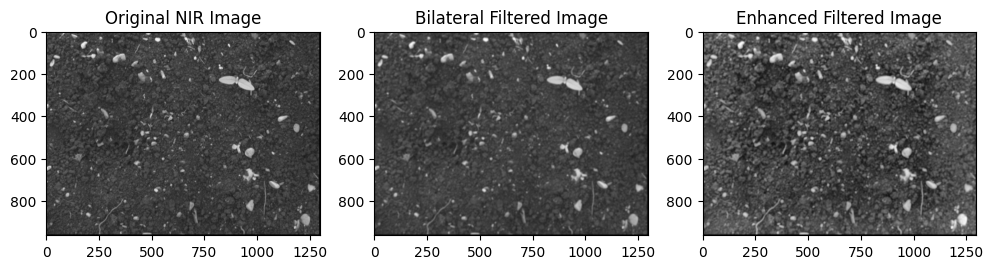

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):

    """
    Apply Gaussian bilateral filter to preserve edges.
    d: Diameter of each pixel neighborhood.
    sigmaColor: Filter sigma in the color space.
    sigmaSpace: Filter sigma in the coordinate space.
    """
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

def enhance_contrast(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Enhance contrast using CLAHE (Contrast Limited Adaptive Histogram Equalization)
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(image)

# Load the NIR image
nir_image = cv2.imread('/content/drive/MyDrive/train NIR/jesi_05_12__0_4min_rid_frame104.png', cv2.IMREAD_GRAYSCALE)
if nir_image is not None:
    # Apply the bilateral filter
    filtered_image = apply_bilateral_filter(nir_image, d=9, sigmaColor=75, sigmaSpace=75)

    # Enhance contrast
    enhanced_image = enhance_contrast(filtered_image)

    # Displaying the images
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(nir_image, cmap='gray')
    plt.title('Original NIR Image')
    plt.subplot(1, 3, 2)
    plt.imshow(filtered_image, cmap='gray')
    plt.title('Bilateral Filtered Image')
    plt.subplot(1, 3, 3)
    plt.imshow(enhanced_image, cmap='gray')
    plt.title('Enhanced Filtered Image')
    plt.show()
else:
    print("Failed to load the NIR image.")


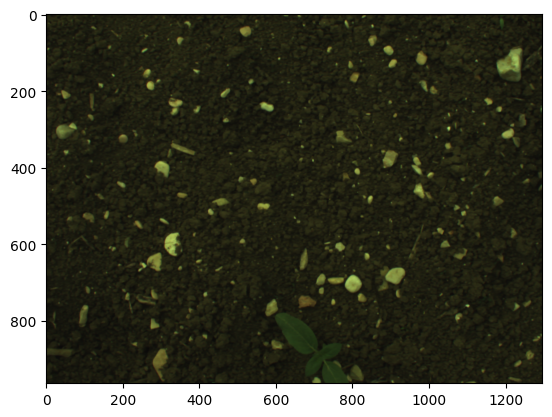

In [ ]:
import matplotlib.pyplot as plt
import cv2
 # Load and display the combined image
loaded_img = cv2.imread(combined_image_path)
loaded_img = cv2.cvtColor(loaded_img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for visualization
plt.imshow(loaded_img)
plt.show()

In [ ]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy.ndimage import gaussian_laplace

class CombinedDataset(Dataset):
    def __init__(self, combined_image_dir, annotation_dir):
        self.combined_image_dir = combined_image_dir
        self.annotation_dir = annotation_dir
        self.image_mask_pairs = self._find_matching_files()

        # Normalization for RGB+NIR images
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            # Normalizing including the NIR channel. Extend mean and std if NDVI is used as a fourth channel
            transforms.Normalize(mean=[0.485, 0.456, 0.406, 0.45], std=[0.229, 0.224, 0.225, 0.225])
        ])

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        combined_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)  # Load combined RGB+NIR image
        mask_rgb = cv2.imread(mask_path, cv2.IMREAD_COLOR)  # Load mask in color
        mask = self.convert_rgb_to_labels(mask_rgb)  # Convert RGB mask to single-channel class labels



        img_tensor = self.transforms(combined_img)
        mask_tensor = torch.from_numpy(mask).long()

        return img_tensor, mask_tensor



    def _find_matching_files(self):
        # Find all matching image-mask pairs
        image_mask_pairs = []
        image_files = os.listdir(self.combined_image_dir)
        for img_file in image_files:
            mask_filename = img_file.replace("combined_", "")
            img_path = os.path.join(self.combined_image_dir, img_file)
            mask_path = os.path.join(self.annotation_dir, mask_filename)
            if os.path.exists(mask_path):
                image_mask_pairs.append((img_path, mask_path))
            else:
                print(f"Warning: Corresponding mask not found for {img_file}")
        return image_mask_pairs

    def convert_rgb_to_labels(self, mask_rgb):
        # Convert RGB mask to single-channel class labels
        mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
        mask[np.all(mask_rgb == [0, 0, 0], axis=-1)] = 0  # Soil
        mask[np.all(mask_rgb == [0, 255, 0], axis=-1)] = 1  # Crop
        mask[np.all(mask_rgb == [0, 0, 255], axis=-1)] = 2  # Weeds
        return mask

# Example usage:
combined_image_dir = '/content/drive/MyDrive/combined_images'
annotation_dir = '/content/drive/MyDrive/combined_annotations'
dataset = CombinedDataset(combined_image_dir, annotation_dir)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

for images, masks in loader:
    print("Batch images shape:", images.shape)
    print("Batch masks shape:", masks.shape)



Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 964, 1296])
Batch masks shape: torch.Size([4, 964, 1296])
Batch images shape: torch.Size([4, 4, 96

One of the advantages of U-Net compared to other segmentation models is its effectiveness to work with a small amount of training
data.
U-Net model consists of two main parts, downsampling in the first
part and upsampling in the second. The downsampling involves pooling
layers to reduce the image resolution while keeping the number of
channels. This procedure is important to reduce the complexity and
abstract the information. On the other hand, the upsampling part consists of several convolutional layers that are used to increase the resolution and produce more precise output.

The DoubleConv class represents a sequence of two convolutional operations, each followed by batch normalization and a ReLU activation function. It's a basic building block used in U-Net for both the encoder (downsampling path) and the decoder (upsampling path).
The Down class represents the downsampling step of the U-Net, which reduces the spatial dimensions of the feature maps while increasing the feature channels. It uses max pooling followed by a DoubleConv sequence.
The Up class is used in the upsampling path of the U-Net, where the feature maps are increased in spatial dimensions. It can use either bilinear upsampling followed by a DoubleConv sequence or transposed convolutions (ConvTranspose2d).
The OutConv is a simple 1x1 convolution used at the output of the U-Net to map the final feature maps to the number of classes for segmentation.

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""
#     def __init__(self, in_channels, out_channels, mid_channels=None):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(mid_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# class Down(nn.Module):
#     """Downscaling with maxpool then double conv"""
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, out_channels)
#         )

#     def forward(self, x):
#         return self.maxpool_conv(x)

# class Up(nn.Module):
#     """Upscaling then double conv"""
#     def __init__(self, in_channels, out_channels, bilinear=True):
#         super().__init__()
#         # if bilinear, use the normal convolutions to reduce the number of channels
#         if bilinear:
#             self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#             self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
#         else:
#             self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
#             self.conv = DoubleConv(in_channels, out_channels)

#     def forward(self, x1, x2):
#         x1 = self.up(x1)
#         # input is CHW
#         diffY = x2.size()[2] - x1.size()[2]
#         diffX = x2.size()[3] - x1.size()[3]

#         x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
#                         diffY // 2, diffY - diffY // 2])
#         # if you have padding issues, see
#         # https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
#         x = torch.cat([x2, x1], dim=1)
#         return self.conv(x)

# class OutConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(OutConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

#     def forward(self, x):
#         return self.conv(x)

# class UNet(nn.Module):
#     def __init__(self, n_channels, n_classes, bilinear=True):
#         super(UNet, self).__init__()
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.bilinear = bilinear

#         self.inc = DoubleConv(n_channels, 64)
#         self.down1 = Down(64, 128)
#         self.down2 = Down(128, 256)
#         self.down3 = Down(256, 512)
#         factor = 2 if bilinear else 1
#         self.down4 = Down(512, 1024 // factor)
#         self.up1 = Up(1024, 512 // factor, bilinear)
#         self.up2 = Up(512, 256 // factor, bilinear)
#         self.up3 = Up(256, 128 // factor, bilinear)
#         self.up4 = Up(128, 64, bilinear)
#         self.outc = OutConv(64, n_classes)

#     def forward(self, x):
#         x1 = self.inc(x)
#         x2 = self.down1(x1)
#         x3 = self.down2(x2)
#         x4 = self.down3(x3)
#         x5 = self.down4(x4)
#         x = self.up1(x5, x4)
#         x = self.up2(x, x3)
#         x = self.up3(x, x2)
#         x = self.up4(x, x1)
#         logits = self.outc(x)
#         return logits



To incorporate a ResNet-50 backbone into the U-Net architecture, we can utilize the pre-trained ResNet-50 model from torchvision.models as the encoder. We will retain the original ResNet-50 up to its final convolutional layer and remove the fully connected layers since they are not needed for segmentation tasks.

In segmentation tasks, the goal is to assign a class label to each pixel in an image, which requires preserving spatial information throughout the entire process. Fully connected (FC) layers, also known as dense layers, do not preserve spatial relationships between pixels because they connect every input to every output, effectively losing the spatial structure of the image data. This characteristic makes them less suitable for tasks where the spatial arrangement of the data is crucial, like in image segmentation.

The main goal of this function is to ensure that two tensors (from the encoder and decoder parts of a segmentation network like U-Net) match in spatial dimensions (height and width). This matching is necessary because the feature maps from the encoder that are skipped and concatenated with the decoder outputs must have the same dimensions to perform element-wise operations successfully.

In [ ]:
import torch
import torch.nn.functional as F
def crop(encoder_layer, decoder_layer):
    if encoder_layer.size()[2] != decoder_layer.size()[2] or encoder_layer.size()[3] != decoder_layer.size()[3]:
        encoder_layer = F.interpolate(encoder_layer, size=(decoder_layer.size()[2], decoder_layer.size()[3]), mode='bilinear', align_corners=True)
    return encoder_layer


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models


class ResNetUNet(nn.Module):
    def __init__(self, n_classes, n_channels=4, pretrained=True):
        super(ResNetUNet, self).__init__()
        self.resnet = models.resnet50(pretrained=pretrained)
        self.resnet.conv1 = nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder1 = self.resnet.layer1
        self.encoder2 = self.resnet.layer2
        self.encoder3 = self.resnet.layer3
        self.encoder4 = self.resnet.layer4
        self.decoder4 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2)
        self.decoder3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder1 = nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2)
        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.resnet.conv1(x)
        x1 = self.resnet.bn1(x1)
        x1 = self.resnet.relu(x1)
        x1 = self.resnet.maxpool(x1)
        e1 = self.encoder1(x1)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        d4 = self.decoder4(e4) + crop(e3, self.decoder4(e4))
        d3 = self.decoder3(d4) + crop(e2, self.decoder3(d4))
        d2 = self.decoder2(d3) + crop(e1, self.decoder2(d3))
        d1 = self.decoder1(d2)
        out = self.final_conv(d1)
        out = F.interpolate(out, size=(964, 1296), mode='bilinear', align_corners=True)  # Resize to match input
        return out




Dice Loss is particularly effective for unbalanced segmentation tasks because it directly tries to optimize the overlap between the predicted and true mask, making it a good choice for datasets where some classes are much less frequent. Combining Dice Loss with Cross-Entropy allows the model to learn from the pixel-wise classification accuracy (Cross-Entropy) while also optimizing for the overlap in the predicted segmentation masks (Dice), providing a more robust training process.

In [ ]:
import torch.nn as nn
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy(inputs, targets)
        dl_loss = self.dice_loss(inputs, targets)
        return ce_loss + dl_loss

class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = F.softmax(inputs, dim=1)
        targets = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (inputs * targets).sum(dim=(2,3))
        dice = (2.*intersection + smooth) / (inputs.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + smooth)

        return 1 - dice.mean()


In [ ]:
def iou_per_class(outputs, labels, n_classes):
    # Convert outputs to class predictions
    _, predictions = torch.max(outputs, 1)
    ious = []
    for cls in range(n_classes):
        prediction = (predictions == cls)
        truth = (labels == cls)
        intersection = torch.logical_and(prediction, truth).sum().item()
        union = torch.logical_or(prediction, truth).sum().item()
        if union == 0:
            iou = float('nan')  # or some other placeholder for no prediction
        else:
            iou = intersection / union
        ious.append(iou)
    return ious

The hold-out method involves dividing the dataset into two distinct sets:

Training Set: Used to train the model. This is where the model learns the patterns in the data.
Testing Set: Used to test or evaluate the model. This set is kept separate and is not used during the training phase. It helps to assess how well the model generalizes to new, unseen data.

In [ ]:
from torch.utils.data.dataset import random_split
torch.manual_seed(0)

# Assuming the total dataset size and test size are known
total_size = len(dataset)
test_size = 64
train_size = total_size - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
# from sklearn.model_selection import KFold

# from sklearn.model_selection import KFold

# # Define the number of folds
# num_folds = 5

# # Get indices of the dataset
# dataset_indices = list(range(len(dataset)))

# # Initialize KFold cross-validation
# kf = KFold(n_splits=num_folds, shuffle=True)

# # Iterate over each fold
# for fold, (train_indices, test_indices) in enumerate(kf.split(dataset_indices)):
#     print(f"Fold {fold+1}/{num_folds}")

#     # Create train and test datasets for this fold
#     train_dataset = torch.utils.data.Subset(dataset, train_indices)
#     test_dataset = torch.utils.data.Subset(dataset, test_indices)

#     # Create data loaders for train and test datasets
#     train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
#     test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

#     # Now you can train your model using train_loader and evaluate it using test_loader
#     # Perform training and evaluation for this fold...


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [ ]:
import torch
import os
torch.cuda.empty_cache()  # Free unused memory
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import gc
# Assuming UNet, CombinedLoss, and iou are defined



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize your UNet model with 4 input channels and 3 classes for output

model = ResNetUNet(n_classes=3, n_channels=4, pretrained=True).to(device)
# model = UNetResNet(num_classes=3).to(device)


# At appropriate points in your code, especially in loops
# del model
# gc.collect()
torch.cuda.empty_cache()  # Frees unused memory from PyTorch


# Define your optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = CombinedLoss()  # This combines Cross-Entropy and Dice Loss

num_epochs = 8  # Define the number of epochs you want to train for









# Set environment variable for memory allocation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear any cached memory (optional, often has no effect)
torch.cuda.empty_cache()

# Assuming train_loader and test_loader are defined using CombinedDataset
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Average Training Loss: {avg_loss:.4f}")

    # Evaluation on test set
model.eval()
with torch.no_grad():
  ious_per_class = { 'weed': [], 'crop': [], 'soil': [] }


    #
    #
  for images, masks in test_loader:
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    ious = iou_per_class(outputs, masks, n_classes=3)

    for i, cls_name in enumerate(['soil', 'crop', 'weed']):
      ious_per_class[cls_name].append(ious[i])

  for cls_name in ['soil', 'crop', 'weed']:
    class_iou = np.nanmean(ious_per_class[cls_name])
    print(f"{cls_name.capitalize()} IoU: {class_iou:.4f}")



  mean_iou = np.nanmean([val for sublist in ious_per_class.values() for val in sublist])
  print(f"Mean IoU on test set: {mean_iou:.4f}")





/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 101MB/s]


Epoch 1, Average Training Loss: 0.8813
Epoch 2, Average Training Loss: 0.4220
Epoch 3, Average Training Loss: 0.2620
Epoch 4, Average Training Loss: 0.2411
Epoch 5, Average Training Loss: 0.2193
Epoch 6, Average Training Loss: 0.4671
Epoch 7, Average Training Loss: 0.3048
Epoch 8, Average Training Loss: 0.2185
Soil IoU: 0.9913
Crop IoU: 0.8382
Weed IoU: 0.6338
Mean IoU on test set: 0.8211


  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-9uh1qbmr
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf.git /tmp/pip-req-build-9uh1qbmr
  Resolved https://github.com/lucasb-eyer/pydensecrf.git to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pydensecrf: filename=pydensecrf-1.0-cp310-cp310-linux_x86_64.whl size=3405188 sha256=c54ef0536276727899c2ea1e550aed235fd122ce0a2d8c59b8cfc14dfa1682ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6zq8c84/wheels/01/5b/61/87443ed3bf03dd2940375cf2f8b6fba88efece935465e490b0
Successfully built pydensecrf
